# Interactive clustering and annotation
## VAE_SBF2/CondVAE_siRNA-CC

This notebook creates a sub-subsampled mpp data `aggregated/sub-0.005_sub-0.33` from the previously created mpp data `aggregated/sub-0.005`, as the latter mpp data was too big for interactive clustering, and 1/3 of the data is sufficient to get good clusters.

Then, the clusterings `clustering_res0.9_seed1.npy`, `clustering_res0.9_seed2.npy`, `clustering_res0.9_seed3.npy` are created.

In [1]:
from miann.constants import EXPERIMENT_DIR
from miann.data import MPPData
from miann.tl import Experiment
from miann.tl import Cluster
from miann.tl._cluster import add_clustering_to_adata
from miann.pl import annotate_img
import os
import numpy as np
import scanpy as sc

In [2]:
exp_name = 'VAE_SBF2/CondVAE_siRNA-CC'
cluster_data_dir = os.path.join(exp_name, 'aggregated/sub-0.005_sub-0.33')

## Subsample subsampled data

In [4]:
mpp_data = MPPData.from_data_dir(f'{exp_name}/aggregated/sub-0.005', 
                                 optional_keys=['mpp', 'latent', 'labels', 'conditions', 'umap'], base_dir=EXPERIMENT_DIR)

# subsample by 0.33
np.random.seed(0)
mask = np.random.choice(len(mpp_data.obj_ids), size=int(len(mpp_data.obj_ids)*0.33), replace=False)
mpp_data.apply_mask(mask)
mpp_data.write(os.path.join(EXPERIMENT_DIR, cluster_data_dir))

In [10]:
import json
params = json.load(open(os.path.join(EXPERIMENT_DIR, exp_name, 'aggregated/sub-0.005/cluster_params.json')))
params['cluster_data_dir'] = cluster_data_dir
json.dump(params, open(os.path.join(EXPERIMENT_DIR, cluster_data_dir, 'cluster_params.json'), 'w'), indent=4)

## Cluster data

Load the MPP from file

In [3]:
# load cl
cl = Cluster.from_cluster_data_dir(cluster_data_dir)
# get adata object
adata = cl.cluster_mpp.get_adata(X='mpp', obsm={'X_latent': 'latent', 'X_umap': 'umap'})

/Users/hannah.spitzer/opt/miniconda3/envs/pelkmans-3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Cluster the latent space using leiden (**Skip this if already done**)

In [ ]:
sc.pp.neighbors(adata, use_rep='X_latent')
sc.tl.leiden(adata, resolution=0.9, key_added='clustering_res0.9_sub-0.33_seed1', random_state=1)
sc.tl.leiden(adata, resolution=0.9, key_added='clustering_res0.9_sub-0.33_seed2', random_state=2)
sc.tl.leiden(adata, resolution=0.9, key_added='clustering_res0.9_sub-0.33_seed3', random_state=3)

# write clustering to disk
#np.save(os.path.join(EXPERIMENT_DIR, cluster_data_dir, 'clustering_res0.9_sub-0.33_seed1'), adata.obs['clustering_res0.9_sub-0.33_seed1'])
#np.save(os.path.join(EXPERIMENT_DIR, cluster_data_dir, 'clustering_res0.9_sub-0.33_seed2'), adata.obs['clustering_res0.9_sub-0.33_seed2'])
#np.save(os.path.join(EXPERIMENT_DIR, cluster_data_dir, 'clustering_res0.9_sub-0.33_seed3'), adata.obs['clustering_res0.9_sub-0.33_seed3'])

## Explore clustered data

In [6]:
# comment in for logging messages
#import logging
#logging.basicConfig(level=logging.INFO)

In [3]:
# quick plotting functions for looking at results
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_loadings(adata,var='clustering'):
    pixel_values_annotated = pd.concat([
        pd.DataFrame(adata.X,columns=adata.var_names).reset_index(drop=True),
        adata.obs[[var]].reset_index(drop=True)],
        axis=1)
    #col_standard = sns.clustermap(pixel_values_annotated.groupby(var).aggregate('mean'), z_score=0, cmap="vlag", figsize=[10,4],vmin=-3, vmax=3)
    row_standard = sns.clustermap(pixel_values_annotated.groupby(var).aggregate('mean'), z_score=1, cmap="vlag", figsize=[14,9],vmin=-3, vmax=3, method='ward')
    
def plot_count_per_condition(var='clustering'):
    count_per_condition = adata.obs[['mapobject_id','perturbation_duration', var]].groupby(['perturbation_duration', var]).agg(['count'])
    count_per_condition.reset_index(level=0,inplace=True)
    count_per_condition = count_per_condition.pivot(columns='perturbation_duration')
    count_per_condition = count_per_condition / count_per_condition.sum()
    count_per_condition.index = count_per_condition.index.astype(int)
    count_per_condition = count_per_condition.sort_index()

    plt.rcParams['figure.figsize'] = [10, 14]
    fig,axes = plt.subplots(2,1)

    axes[0] = count_per_condition.plot.bar(ax=axes[0])
    axes[1] = sns.heatmap(count_per_condition.transpose())

# projection function to example subset
def project_clustering(cl, mpp_data: MPPData, obj_ids=[], num_objs=5, cluster_name='clustering'):
    """ 
    project clustering to example obj_ids. 
    Either a list of obj_ids can be specified, or a number of randomly drawn objects.

    Args:
        cl: reference clustering
        mpp_data: data containing the obj_ids to project
    """
    # set cluster_name to project
    cl.set_cluster_name(cluster_name)
    if len(obj_ids)==0:
        rng = np.random.default_rng(seed=42)
        obj_ids = rng.choice(mpp_data.unique_obj_ids, num_objs, replace=False)
    sub_mpp_data = mpp_data.subset(obj_ids=obj_ids, copy=True)
    sub_mpp_data = cl.project_clustering(sub_mpp_data)
    return sub_mpp_data

def load_full_data_dict(exp_name, keys=['x', 'y', 'obj_ids', 'latent']):
    """
    load mpp_datas used in experiment exp_name in a dict.
    NOTE: this might take a few minutes, as all data needs to be loaded. 
    
    Args:
        keys: controls which np data matrices are being loaded. Excluding mpp here speeds up loading
    """
    exp = Experiment.from_dir(exp_name)
    mpp_datas = {}
    for data_dir in exp.data_params['data_dirs']:
        print(data_dir)
        try:
            mpp_datas[data_dir] = MPPData.from_data_dir(data_dir, base_dir=os.path.join(exp.full_path, 'aggregated/full_data'), 
                                                        keys=keys, optional_keys=[])
        except FileNotFoundError as e:
            continue
    return mpp_datas

def get_clustered_cells(mpp_datas, cl, cluster_name, num_objs=5):
    """
    get x example cells for each well. Returns a dict, containing clustering cluster_name and colored cells in cluster_name_colored
    """
    cl.set_cluster_name(cluster_name)
    res = {cluster_name:{}, cluster_name+'_colored':{}}
    for data_dir, mpp_data in mpp_datas.items():
        print(data_dir)
        sub_mpp_data = project_clustering(cl, mpp_data, num_objs=num_objs, cluster_name=cluster_name)
        # if only need colored cells, can pass annotation_kwargs to get_object_imgs
        res[cluster_name][data_dir] = sub_mpp_data.get_object_imgs(data=cluster_name)  #annotation_kwargs={'color': True, 'annotation': cl.cluster_annotation})
        res[cluster_name+'_colored'][data_dir] = [annotate_img(img, annotation=cl.cluster_annotation, from_col=cluster_name, color=True) for img in res[cluster_name][data_dir]]
    return res

First load the multiplexed pixel profile (MPP)

In [4]:
# load cl
cl = Cluster.from_cluster_data_dir(cluster_data_dir)
# get adata object
adata = cl.cluster_mpp.get_adata(X='mpp', obsm={'X_latent': 'latent', 'X_umap': 'umap'})

/home/icb/hannah.spitzer/miniconda3/envs/pelkmans-3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


The different clusterings have already been saved in the clustering object, we now want to add them to the anndata

In [5]:
# add clustering and colormap (from cluster_name_annotation.csv) to adata
cl.set_cluster_name('clustering_res0.9_sub-0.33_seed1') 
add_clustering_to_adata(os.path.join(EXPERIMENT_DIR, cluster_data_dir),
                        'clustering_res0.9_sub-0.33_seed1',
                        adata,
                        cl.cluster_annotation)

cl.set_cluster_name('clustering_res0.9_sub-0.33_seed2') 
add_clustering_to_adata(os.path.join(EXPERIMENT_DIR, cluster_data_dir),
                        'clustering_res0.9_sub-0.33_seed2',
                        adata,
                        cl.cluster_annotation)

cl.set_cluster_name('clustering_res0.9_sub-0.33_seed3') 
add_clustering_to_adata(os.path.join(EXPERIMENT_DIR,cluster_data_dir),
                        'clustering_res0.9_sub-0.33_seed3',
                        adata,
                        cl.cluster_annotation)

## Plot clustering results

Print the names of variables in the adata object

In [7]:
adata.var_names

Index(['01_CDK9_pT186', '01_PABPC1', '02_CDK7', '02_RPS6_pS235_S236',
       '03_CDK9', '03_RPS6', '04_MAPK1_pT202_T204', '05_GTF2B', '05_Sm',
       '06_CALR', '06_CTNNB1', '07_POLR2A', '07_SETD1A', '08_H3K4me3',
       '08_PXN', '09_CCNT1', '09_SRRM2', '10_H3K27ac', '10_POL2RA_pS2',
       '11_KPNA2_MAX', '11_PML', '12_RB1_pS807_S811', '12_YAP1', '13_PABPN1',
       '13_POL2RA_pS5', '14_HSPD1', '14_PCNA', '15_SON', '15_U2SNRNPB',
       '16_GOLGA2', '16_H3', '17_HDAC3', '17_SRSF2', '18_NONO', '19_KPNA1_MAX',
       '19_TUBA1A', '20_ALYREF', '20_SP100', '21_COIL', '21_NCL', '22_DDX6',
       '00_DAPI', '07_H2B'],
      dtype='object', name='name')

The following is a UMAP of the latent space coordinates of each pixel. It is useful to check that the clustering algorithm is doing something sensible, and also that the conditions used in the autoencoder don't end up in different regions of the latent space UMAP (which would indicate that the conditional autoencoder was not able to generate a condition-independent representation). Channel intensities can also be visualised here, which is useful if you have some markers for known structures (e.g. NCL, H3, TUB1A1) 

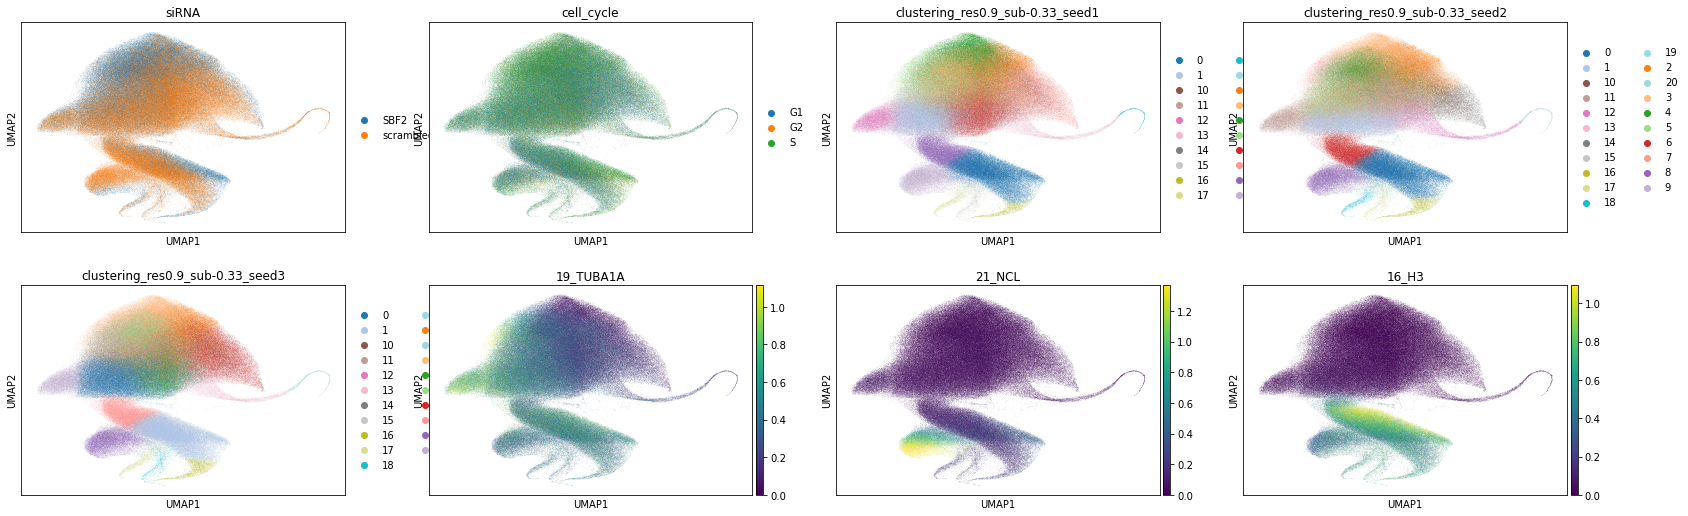

In [18]:
plt.rcParams['figure.figsize'] = [6, 4]
sc.pl.umap(adata, color=['siRNA',
                         'cell_cycle',
                         'clustering_res0.9_sub-0.33_seed1',
                         'clustering_res0.9_sub-0.33_seed2', 
                         'clustering_res0.9_sub-0.33_seed3',
                         '19_TUBA1A',
                         '21_NCL',
                         '16_H3'], vmax='p99')

To get an idea of what cellular compartments the channels correspond to, it is best to plot the mean intensity of each channel in each cluster. The `plot_loadings` function is used for this 

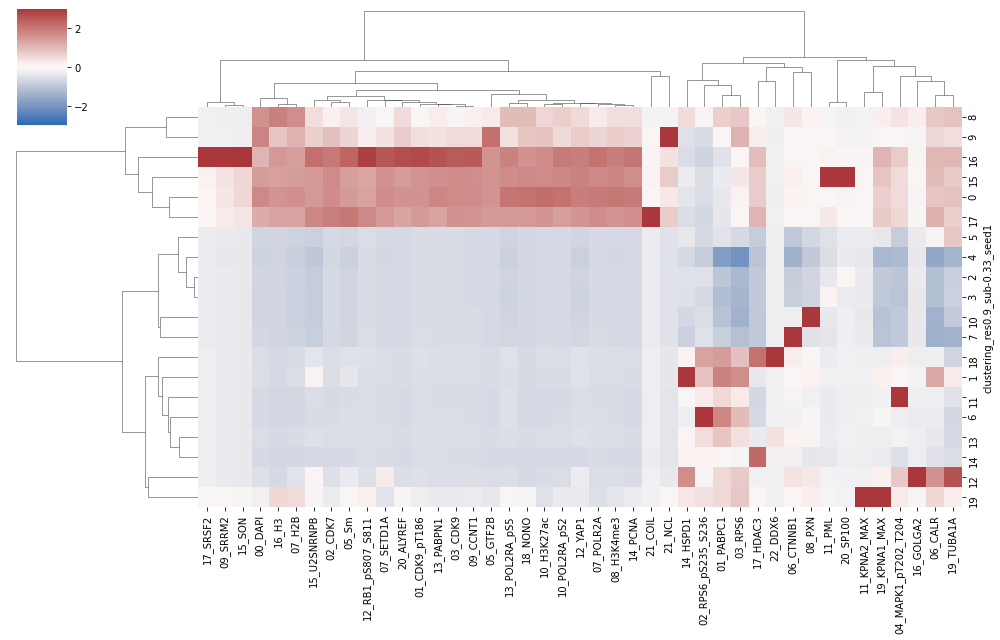

In [19]:
plot_loadings(adata, 'clustering_res0.9_sub-0.33_seed1')
#plot_loadings(adata, 'clustering_res0.9_sub-0.33_seed2')
#plot_loadings(adata, 'clustering_res0.9_sub-0.33_seed3')

It is also very useful to plot the clusters directly out over some example cells. The `get_clustered_cells` function will return some random cells from each well of the experiment

In [9]:
# NOTE: this may take a couple of minutes
# load data
mpp_datas = load_full_data_dict(exp_name)
# project clustering to some example cells
example_cells = {}
example_cells.update(get_clustered_cells(mpp_datas, cl, 'clustering_res0.9_sub-0.33_seed1', num_objs=3))
example_cells.update(get_clustered_cells(mpp_datas, cl, 'clustering_res0.9_sub-0.33_seed2', num_objs=3))
example_cells.update(get_clustered_cells(mpp_datas, cl, 'clustering_res0.9_sub-0.33_seed3', num_objs=3))

HeLa_SBF2/K18
HeLa_SBF2/L19
HeLa_SBF2/M18
HeLa_scrambled/K19
HeLa_scrambled/L18
HeLa_scrambled/M19
HeLa_SBF2/K18
HeLa_SBF2/L19
HeLa_SBF2/M18
HeLa_scrambled/K19
HeLa_scrambled/L18
HeLa_scrambled/M19
HeLa_SBF2/K18
HeLa_SBF2/L19
HeLa_SBF2/M18
HeLa_scrambled/K19
HeLa_scrambled/L18
HeLa_scrambled/M19
HeLa_SBF2/K18
HeLa_SBF2/L19
HeLa_SBF2/M18
HeLa_scrambled/K19
HeLa_scrambled/L18
HeLa_scrambled/M19


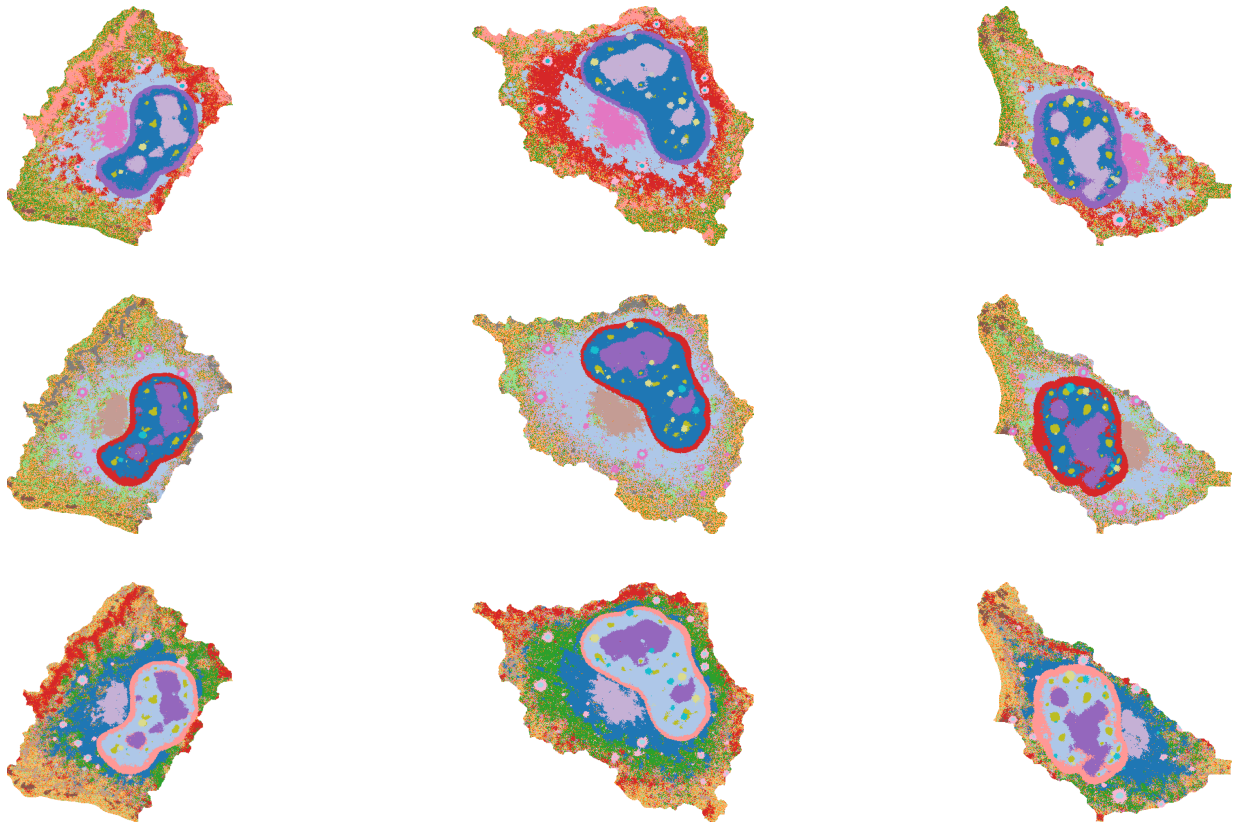

In [10]:
# plot example cells
data_dir = 'HeLa_scrambled/K19'
fig, axes = plt.subplots(3,3, figsize=(25,15))
for i in range(3):
    axes[0,i].imshow(example_cells['clustering_res0.9_sub-0.33_seed1_colored'][data_dir][i])
    axes[1,i].imshow(example_cells['clustering_res0.9_sub-0.33_seed2_colored'][data_dir][i])
    axes[2,i].imshow(example_cells['clustering_res0.9_sub-0.33_seed3_colored'][data_dir][i])
for ax in axes.flat:
    ax.axis('off')

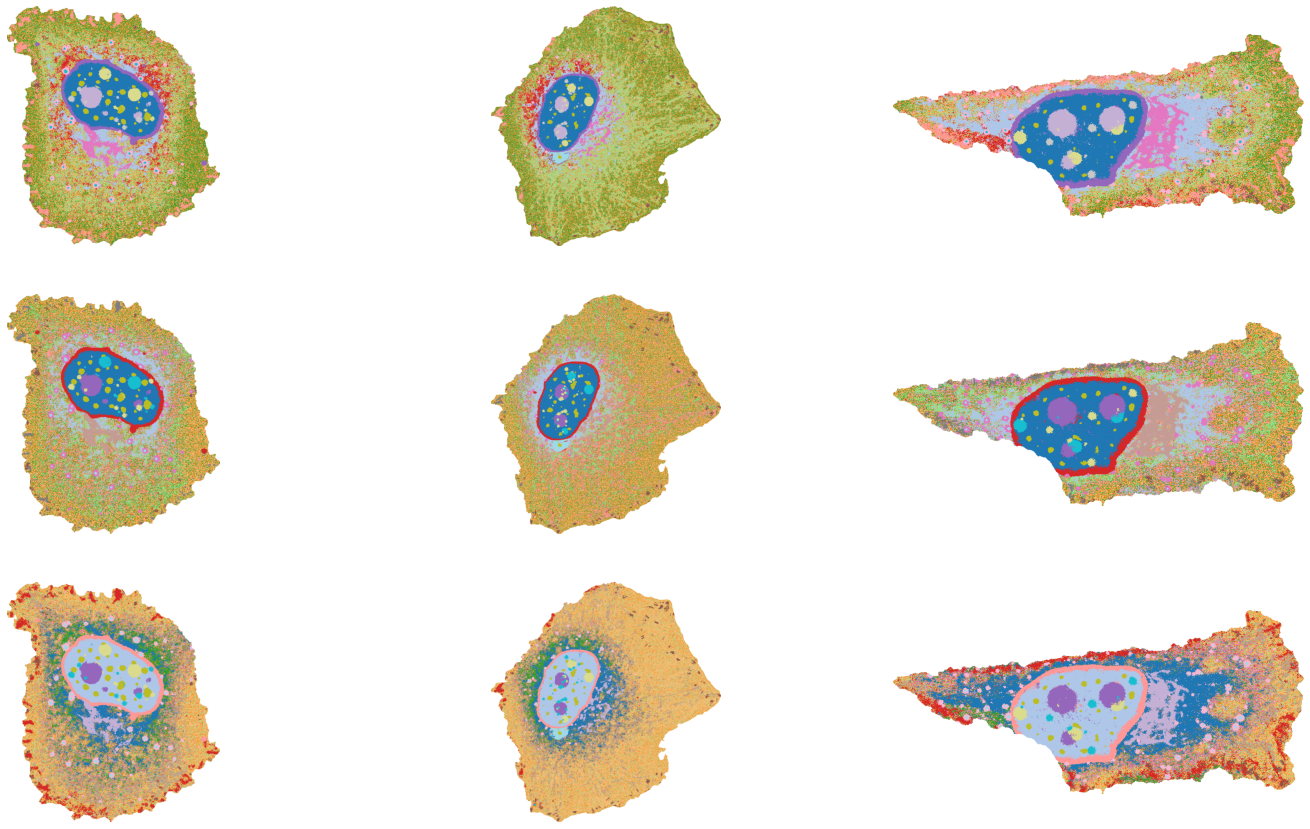

In [11]:
data_dir = 'HeLa_SBF2/M18'
fig, axes = plt.subplots(3,3, figsize=(25,15))
for i in range(3):
    axes[0,i].imshow(example_cells['clustering_res0.9_sub-0.33_seed1_colored'][data_dir][i])
    axes[1,i].imshow(example_cells['clustering_res0.9_sub-0.33_seed2_colored'][data_dir][i])
    axes[2,i].imshow(example_cells['clustering_res0.9_sub-0.33_seed3_colored'][data_dir][i])
for ax in axes.flat:
    ax.axis('off')

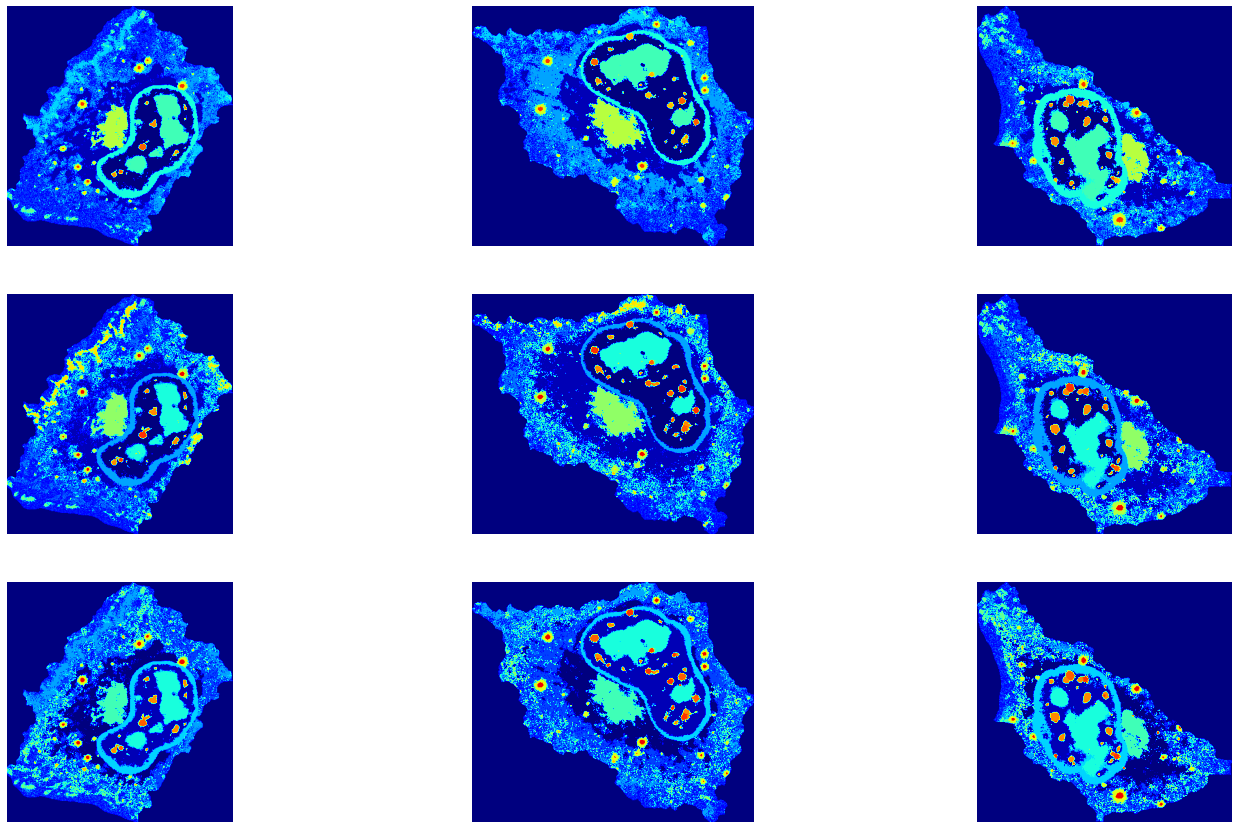

In [12]:
def to_int(arr):
    arr = arr.copy().astype(object)
    arr[arr=='']=0
    arr = arr.astype(int)
    return arr
    #arr.nan_to_num(0)
    
data_dir = 'HeLa_scrambled/K19'
fig, axes = plt.subplots(3,3, figsize=(25,15))
for i in range(3):
    axes[0,i].imshow(to_int(example_cells['clustering_res0.9_sub-0.33_seed1'][data_dir][i]), vmax=21, cmap='jet')
    axes[1,i].imshow(to_int(example_cells['clustering_res0.9_sub-0.33_seed2'][data_dir][i]), vmax=21, cmap='jet')
    axes[2,i].imshow(to_int(example_cells['clustering_res0.9_sub-0.33_seed3'][data_dir][i]), vmax=21, cmap='jet')
for ax in axes.flat:
    ax.axis('off')

## Save annotation

In [8]:
annotation1 = {'0': 'Nucleoplasm',
              '1': 'Mitochondria ER',
              '2': 'Cytoplasm 1',
              '3': 'Cytoplasm 1',
              '4': 'Cytoplasm 1',
              '5': 'Cytoplasm 1',
              '6': 'Cytoplasm 2',
              '7': 'Cell periphery',
              '8': 'Nuclear periphery',
              '9': 'Nucleolus',
              '10': 'Focal adhesions',
              '11': 'Cytoplasm (pERK)',
              '12': 'Golgi',
              '13': 'P-bodies (periphery)',
              '14': 'HDAC3',
              '15': 'PML bodies',
              '16': 'Nuclear speckles',
              '17': 'Cajal bodies',
              '18': 'P-bodies (core)',
              '19': 'Importin alpha'
             }

annotation2 = {'0': 'Nucleoplasm',
              '1': 'Mitochondria 1',
              '2': 'Cytoplasm 1',
              '3': 'Cytoplasm 1',
              '4': 'Cytoplasm 1',
              '5': 'Mitochondria 2',
              '6': 'Nuclear periphery',
              '7': 'Tubulin/Calreticuin',
              '8': 'Nucleolus',
              '9': 'Cytoplasm 2',
              '10': 'Focal adhesions',
              '11': 'Golgi',
              '12': 'P-bodies (periphery)',
              '13': 'Cytoplasm (pERK)',
              '14': 'Cell periphery',
              '15': 'HDAC3',
              '16': 'PML bodies',
              '17': 'Nuclear speckles',
              '18': 'Cajal bodies',
              '19': 'P-bodies (core)',
              '20': 'Importin alpha'
             }

annotation3 = {'0': 'ER (perinuclear)',
              '1': 'Nucleoplasm',
              '2': 'Cytoplasm',
              '3': 'Cytoplasm',
              '4': 'Cytoplasm',
              '5': 'Cytoplasm',
              '6': 'Cell-cell contacts',
              '7': 'Nuclear periphery',
              '8': 'Nucleolus',
              '9': 'Golgi apparatus',
              '10': 'Focal adhesions',
              '11': 'Mitochondria (peripheral)',
              '12': 'Cytoplasm',
              '13': 'P-bodies',
              '14': 'ER (peripheral)',
              '15': 'HDAC3 foci',
              '16': 'Nuclear speckles',
              '17': 'Cajal bodies',
              '18': 'PML bodies',
              '19': 'P-bodies',
              '20': 'Antibody aggregates'
             }

colors = {'ER (perinuclear)':'#069D6B',
          'Nucleoplasm':'#118ab2',
          'Cytoplasm':'#EFDCA9',
          'Cell-cell contacts':'#F06543',
          'Nuclear periphery':'#06d6a0',
          'Nucleolus':'#073b4c',
          'Golgi apparatus':'#F08080',
          'Focal adhesions':'#440D0F',
          'Mitochondria (peripheral)':'#414288',
          'P-bodies':'#A62639',
          'ER (peripheral)':'#053B06',
          'HDAC3 foci':'#90D7FF',
          'Nuclear speckles':'#ffd166',
          'Cajal bodies':'#bca0d0',
          'PML bodies':'#ef476f',
          'Antibody aggregates':'#EBD494'
         }

cl.set_cluster_name('clustering_res0.9_sub-0.33_seed1')
cl.add_cluster_annotation(annotation1, 'annotation')

cl.set_cluster_name('clustering_res0.9_sub-0.33_seed2')
cl.add_cluster_annotation(annotation2, 'annotation')

cl.set_cluster_name('clustering_res0.9_sub-0.33_seed3')
cl.add_cluster_annotation(annotation3, 'annotation', colors=colors)

In [6]:
# define annotation of just cytoplasm/nucleus and cell for calibrating co-occurrence scores later on
annotation_cell1 = {'0': 'cytoplasm',
              '1': 'nucleus',
              '2': 'cytoplasm',
              '3': 'cytoplasm',
              '4': 'cytoplasm',
              '5': 'cytoplasm',
              '6': 'cytoplasm',
              '7': 'nucleus',
              '8': 'nucleus',
              '9': 'cytoplasm',
              '10': 'cytoplasm',
              '11': 'cytoplasm',
              '12': 'cytoplasm',
              '13': 'cytoplasm',
              '14': 'cytoplasm',
              '15': 'cytoplasm',
              '16': 'nucleus',
              '17': 'nucleus',
              '18': 'nucleus',
              '19': 'nucleus',
              '20': 'cytoplasm'
             }
annotation_cell2 = {str(i):'cell' for i in range(21)}
cl.set_cluster_name('clustering_res0.9_sub-0.33_seed3')
cl.add_cluster_annotation(annotation_cell1, 'annotation_cytoplasm')
cl.add_cluster_annotation(annotation_cell2, 'annotation_cell')

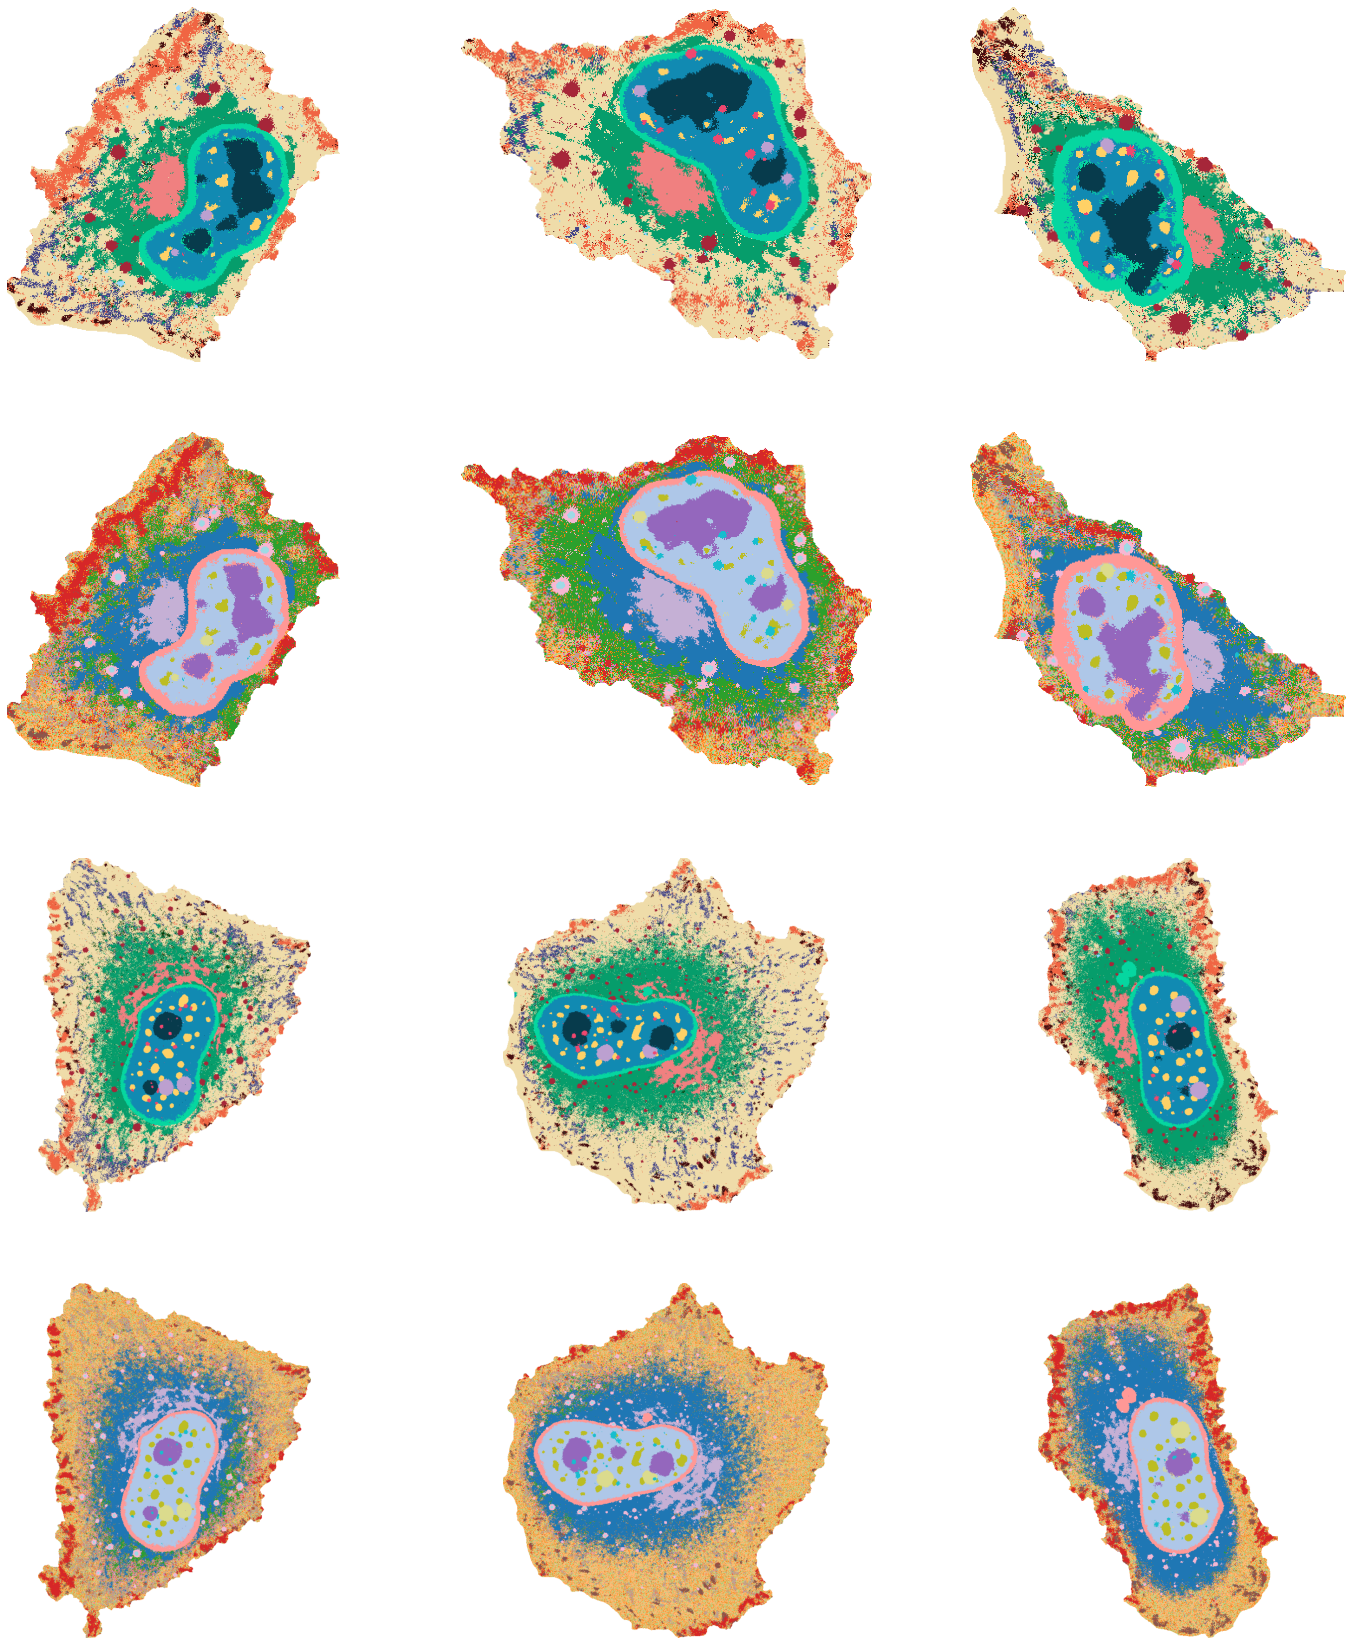

In [300]:
# check out cell colored by new annotation
current_clustering = 'clustering_res0.9_sub-0.33_seed3'

cl.set_cluster_name(current_clustering)
fig, axes = plt.subplots(4,3, figsize=(25,30))
for i in range(3):
    axes[0,i].imshow(annotate_img(example_cells[current_clustering]['HeLa_scrambled/K19'][i], 
                        annotation=cl.cluster_annotation, from_col=cl.config['cluster_name'], to_col='annotation', color=True))
    axes[1,i].imshow(annotate_img(example_cells[current_clustering]['HeLa_scrambled/K19'][i], 
                        annotation=cl.cluster_annotation, from_col=cl.config['cluster_name'], to_col=current_clustering, color=True))
    axes[2,i].imshow(annotate_img(example_cells[current_clustering]['HeLa_SBF2/K18'][i], 
                        annotation=cl.cluster_annotation, from_col=cl.config['cluster_name'], to_col='annotation', color=True))
    axes[3,i].imshow(annotate_img(example_cells[current_clustering]['HeLa_SBF2/K18'][i], 
                        annotation=cl.cluster_annotation, from_col=cl.config['cluster_name'], to_col=current_clustering, color=True))
for ax in axes.flat:
    ax.axis('off')


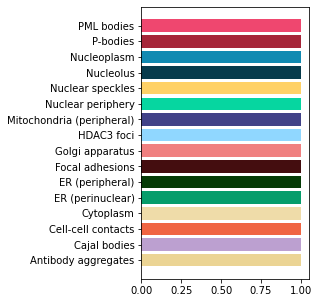

In [301]:
# makeshift legend
plt.rcParams['figure.figsize'] = [3, 5]
cl.set_cluster_name(current_clustering)
df = cl.cluster_annotation.groupby('annotation')['annotation_colors'].first()
plt.barh(y=range(len(df)), width=1, color=df)
_ = plt.yticks(range(len(df)), df.index, rotation=0)

In [7]:
cl.cluster_annotation

clustering_res0.9_sub-0.33_seed3  \
index                                    
0                                    0   
1                                    1   
2                                    2   
3                                    3   
4                                    4   
5                                    5   
6                                    6   
7                                    7   
8                                    8   
9                                    9   
10                                  10   
11                                  11   
12                                  12   
13                                  13   
14                                  14   
15                                  15   
16                                  16   
17                                  17   
18                                  18   
19                                  19   
20                                  20   
21                                       

      clustering_res0.9_sub-0.33_seed3_colors                 annotation  \
index                                                                      
0                                     #1f77b4           ER (perinuclear)   
1                                     #aec7e8                Nucleoplasm   
2                                     #ff7f0e                  Cytoplasm   
3                                     #ffbb78                  Cytoplasm   
4                                     #2ca02c                  Cytoplasm   
5                                     #98df8a                  Cytoplasm   
6                                     #d62728         Cell-cell contacts   
7                                     #ff9896          Nuclear periphery   
8                                     #9467bd                  Nucleolus   
9                                     #c5b0d5            Golgi apparatus   
10                                    #8c564b            Focal adhesions   
11                                    #c49c94  Mitochondria (peripheral)   
12                                    #e377c2                  Cytoplasm   
13                                    #f7b6d2                   P-bodies   
14                                    #7f7f7f            ER (peripheral)   
15                                    #c7c7c7                 HDAC3 foci   
16                                    #bcbd22           Nuclear speckles   
17                                    #dbdb8d               Cajal bodies   
18                                    #17becf                 PML bodies   
19                                    #9edae5                   P-bodies   
20                                    #9edae5        Antibody aggregates   
21                                    #ffffff                              

      annotation_colors annotation_cytoplasm annotation_cytoplasm_colors  \
index                                                                      
0               #069D6B            cytoplasm                     #1f77b4   
1               #118ab2              nucleus                     #9edae5   
2               #EFDCA9            cytoplasm                     #1f77b4   
3               #EFDCA9            cytoplasm                     #1f77b4   
4               #EFDCA9            cytoplasm                     #1f77b4   
5               #EFDCA9            cytoplasm                     #1f77b4   
6               #F06543            cytoplasm                     #1f77b4   
7               #06d6a0              nucleus                     #9edae5   
8               #073b4c              nucleus                     #9edae5   
9               #F08080            cytoplasm                     #1f77b4   
10              #440D0F            cytoplasm                     #1f77b4   
11              #414288            cytoplasm                     #1f77b4   
12              #EFDCA9            cytoplasm                     #1f77b4   
13              #A62639         